### Generate some statistics files

In [4]:
import analysis.stats_utils as stats_utils
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "./applications/driving_intelligence_test/output"
# exp_repo = "/home/zhijie/terasim/TeraSim-NDE-ITE/output"
exp_name="cosim_test_local"

mode = "CAV" # NDE
experiment_record_repo = f"{exp_repo}/{exp_name}/raw_data"
export_stat_dir = f"{exp_repo}/{exp_name}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [5]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 601/601 [00:00<00:00, 1420.52it/s]

info_error:  0


0

In [6]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

### Analyze

#### Import statistics of each experiment

In [8]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1294.5,1144,720,CAV,BV_19.24,-0.008730,2,BV_19.24,-1.0,NaN,NaN,25743.119024,1133.050506,EG_17_1_1_0,rear_end,intersection,4.369559478239125,-1.0,0.0
1,cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


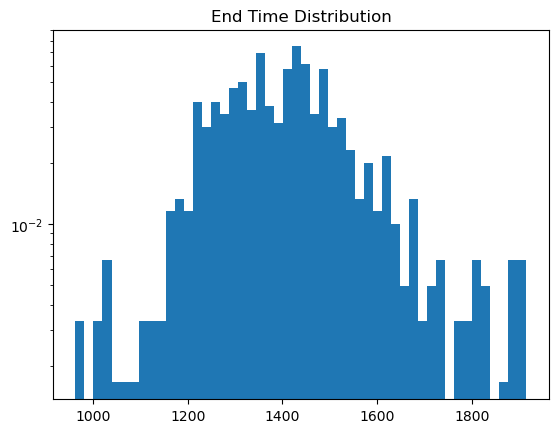

In [9]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

In [10]:
warm_up_time = exp_stats_info["warmup_time"]
estimated_end_time = exp_stats_info["warmup_time"] + exp_stats_info["run_time"]
if mode == "CAV":
    has_collision = (exp_stats_info['crash_veh_1'] == "CAV") | (exp_stats_info['crash_veh_2'] == "CAV")
elif mode == "NDE":
    has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 37 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

In [11]:
collision_df.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1294.5,1144,720,CAV,BV_19.24,-0.008730,2,BV_19.24,-1.0,NaN,NaN,25743.119024,1133.050506,EG_17_1_1_0,rear_end,intersection,4.369559478239125,-1.000000,0.000000
25,cosim_test_local_0_26,1319.7,1123,720,CAV,BV_22.16,4.229031,7,BV_22.16,1.8,Lead,intersection_rearend,35186.493079,2918.945850,EG_17_1_1_0,rear_end,intersection,1.0295327964094838,-0.273076,7.540022
29,cosim_test_local_0_30,979.5,932,720,CAV,BV_21.56,5.259123,6,BV_21.56,2.5,Lead,roundabout_rearend,9150.375860,429.587980,:NODE_7_0_1,rear_end,roundabout,23.686321204834627,0.092966,4.035679
47,cosim_test_local_0_48,1169.3,1144,720,BV_17.52,CAV,5.277120,6,BV_17.52,1.3,LeftFoll,highway_cutin,4121.812059,190.258043,EG_1_3_1_1,rear_end,freeway_1,15.402000976094257,-0.269540,5.078321
77,cosim_test_local_0_78,1063.0,1043,720,BV_22.10,CAV,5.294579,2,BV_22.10,0.6,LeftFoll,highway_cutin,4269.660340,265.460314,EG_1_3_1_1,sideswipe,freeway_1,17.631378174349607,-0.685488,3.279943


In [12]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - exp_stats_info["warmup_time"]).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 601
Number of collision: 37
Collisions with weight less than 1: 34
Importance summation: 0.0005820535811587869
Max weight: 6.658000663686076e-05, Min weight: 5.074823397461178e-06
raw collision rate: 0.06156405990016639
adjusted collision rate (importance): 9.684751766369168e-07
Collision due to traffic light ignorance: 0
Overall maneuvers: 3838
Collision without negligence: 3
Maximum time between collision and negligence: 2.70 s

Overall time: 212836.60 s
Maneuvers per second: 0.018032612811894194
Overall route length: 41402424.65 m
m/s: 194.52680905309128
Overall route length: 25726.273964863427 mile
mile/s: 0.12087335526344353 mile/s
Crash per mile: 2.2624869110612256e-08 crash/mile


In [13]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1294.5,1144,720,CAV,BV_19.24,-0.008730,2,BV_19.24,-1.0,NaN,NaN,25743.119024,1133.050506,EG_17_1_1_0,rear_end,intersection,4.369559478239125,-1.0,0.0
1,cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


In [14]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < exp_stats_info["warmup_time"] + exp_stats_info["run_time"])]
a

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1294.5,1144,720,CAV,BV_19.24,-0.008730,2,BV_19.24,-1.0,NaN,NaN,25743.119024,1133.050506,EG_17_1_1_0,rear_end,intersection,4.369559478239125,-1.0,0.0
1,cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,cosim_test_local_0_596,1445.4,993,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,101966.018120,2775.432946,NaN,NaN,NaN,None,-10.0,NaN
596,cosim_test_local_0_597,1328.7,984,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,68265.664639,4292.945605,NaN,NaN,NaN,None,-10.0,NaN
598,cosim_test_local_0_599,1550.4,1181,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,70243.314155,4642.450564,NaN,NaN,NaN,None,-10.0,NaN
599,cosim_test_local_0_600,1516.3,1042,720,NaN,NaN,-0.130942,30,NaN,-1.0,NaN,NaN,105388.061821,4396.494751,NaN,NaN,NaN,None,-10.0,NaN


In [15]:
if mode == "NDE":

    is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
    is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
    has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
    bv_22_collision_df = collision_df[has_bv_22]

    total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

    num_bv_22_expr = np.sum(has_bv_22)
    bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
    power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
    bv_22_importance = np.sum(power_bv_22_weight)

    print("Number of bv_22 collision:", num_bv_22_expr)
    print("Total bv_22 distance:", total_bv_22_distance)
    print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
    print("Raw collision rate:", num_bv_22_expr / num_experiments)
    print("Collision rate:", bv_22_importance / num_experiments)
    print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

### Crash Distribution (with negligence)

In [16]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & has_collision & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [17]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1294.5,1144,720,CAV,BV_19.24,-0.008730,2,BV_19.24,-1.0,NaN,NaN,25743.119024,1133.050506,EG_17_1_1_0,rear_end,intersection,4.369559478239125,-1.0,0.0
1,cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


In [18]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print("negligence collision number:", len(neg_caused_collision), "non-negligence collision number:", len(no_neg_realated_collision))

34 3


In [19]:
neg_caused_collision["lane_id"].value_counts()

EG_1_3_1_1      23
EG_17_1_1_0      2
EG_9_1_1_0       2
:NODE_17_1_0     2
:NODE_7_0_1      1
:NODE_18_2_0     1
:NODE_26_1_0     1
EG_14_2_1_0      1
EG_16_23_1_0     1
Name: lane_id, dtype: int64

In [20]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

EG_17_1_1_0      1
:NODE_22_3_0     1
:NODE_18_15_0    1
Name: lane_id, dtype: int64
3


In [21]:
neg_caused_collision.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
25,cosim_test_local_0_26,1319.7,1123,720,CAV,BV_22.16,4.229031,7,BV_22.16,1.8,Lead,intersection_rearend,35186.493079,2918.945850,EG_17_1_1_0,rear_end,intersection,1.0295327964094838,-0.273076,7.540022
29,cosim_test_local_0_30,979.5,932,720,CAV,BV_21.56,5.259123,6,BV_21.56,2.5,Lead,roundabout_rearend,9150.375860,429.587980,:NODE_7_0_1,rear_end,roundabout,23.686321204834627,0.092966,4.035679
47,cosim_test_local_0_48,1169.3,1144,720,BV_17.52,CAV,5.277120,6,BV_17.52,1.3,LeftFoll,highway_cutin,4121.812059,190.258043,EG_1_3_1_1,rear_end,freeway_1,15.402000976094257,-0.269540,5.078321
77,cosim_test_local_0_78,1063.0,1043,720,BV_22.10,CAV,5.294579,2,BV_22.10,0.6,LeftFoll,highway_cutin,4269.660340,265.460314,EG_1_3_1_1,sideswipe,freeway_1,17.631378174349607,-0.685488,3.279943
101,cosim_test_local_0_102,1024.5,1005,720,BV_8.71,CAV,5.168000,31,BV_8.71,0.6,LeftFoll,highway_cutin,4109.850786,0.000000,EG_1_3_1_1,sideswipe,freeway_1,18.312956350202114,-1.631489,6.193043


In [22]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [23]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_265134/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,12,0.000067,0.019967,1.110965e-07
1,freeway,sideswipe,11,0.000063,0.018303,1.045143e-07
2,intersection,angle,1,0.000010,0.001664,1.630610e-08
3,intersection,rear,7,0.000425,0.011647,7.070317e-07
4,roundabout,rear,3,0.000018,0.004992,2.952657e-08


In [24]:
if mode == "NDE":

    location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
    proportion = location_distribution["exp_importance"]
    print(proportion)

    plt.figure(figsize=(20, 10))
    plt.subplot(3, 1, 1)
    plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
    # plt.bar(proportion.index, values=proportion)
    plt.title("calibrated")
    plt.subplot(3, 1, 2)
    true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
    plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
    # plt.bar(proportion.index, values=true_dist)
    plt.title("ground truth")

In [25]:
def pie_chart_plot(df, exp_name, feat_name):
    mark = df["location"] == exp_name
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{exp_name}')
    # plt.legend(labels)

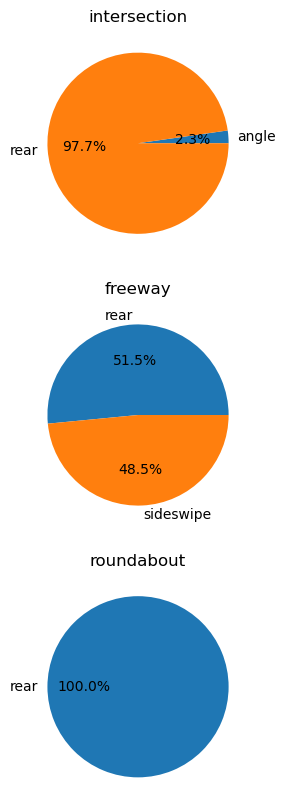

In [26]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [27]:
len(neg_caused_collision)

34

#### Negligence reason

In [28]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,LeftFoll,23,0.000130,0.038270,2.156108e-07
1,intersection,Lead,8,0.000435,0.013311,7.233378e-07
2,roundabout,Lead,3,0.000018,0.004992,2.952657e-08


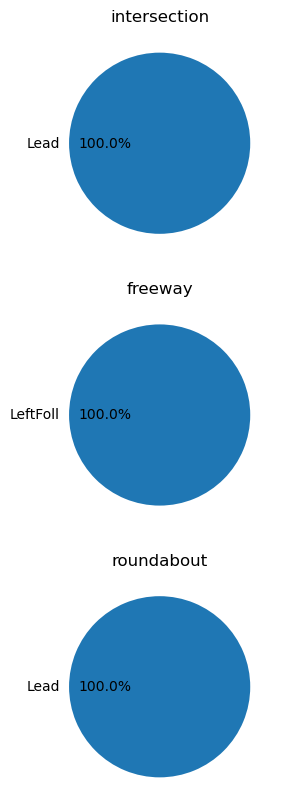

In [29]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [30]:
if mode == "NDE":
    plt.figure(figsize=(30, 10))
    plt.subplot(3, 1, 1)
    pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
    plt.subplot(3, 1, 2)
    pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
    plt.subplot(3, 1, 3)
    pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
    plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,1,0.000006,0.001664,9.817891e-09
1,freeway,sideswipe,1,0.000005,0.001664,8.443966e-09
2,intersection,rear,5,0.000304,0.008319,5.056402e-07
3,roundabout,rear,2,0.000012,0.003328,2.036432e-08


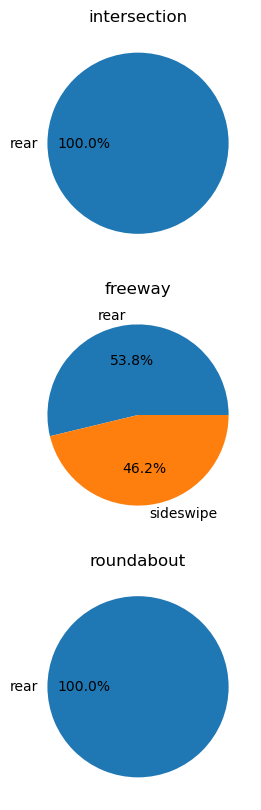

In [31]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [32]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

11


In [33]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
497,cosim_test_local_0_498,1035.9,1006,720,BV_8.56,CAV,5.246566,13,BV_8.56,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,16.205463961489443,-2.818468,3.278143,0.000006,freeway,sideswipe,0.090237
427,cosim_test_local_0_428,1191.5,1173,720,BV_8.69,CAV,5.255296,11,BV_8.69,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,17.232107577641557,-3.146520,4.010660,0.000006,freeway,sideswipe,0.178678
77,cosim_test_local_0_78,1063.0,1043,720,BV_22.10,CAV,5.294579,2,BV_22.10,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,17.631378174349607,-0.685488,3.279943,0.000005,freeway,sideswipe,0.259470
229,cosim_test_local_0_230,1023.9,995,720,BV_8.59,CAV,5.259661,10,BV_8.59,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,17.782380523648442,-0.381857,2.400161,0.000005,freeway,sideswipe,0.347027
153,cosim_test_local_0_154,1184.2,1174,720,BV_8.68,CAV,5.272755,7,BV_8.68,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,17.93261534250115,-0.785081,4.740295,0.000005,freeway,sideswipe,0.431983
424,cosim_test_local_0_425,1159.4,1119,720,BV_17.50,CAV,5.264026,9,BV_17.50,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,17.951452234284886,-2.216251,2.338443,0.000005,freeway,sideswipe,0.518664
101,cosim_test_local_0_102,1024.5,1005,720,BV_8.71,CAV,5.168000,31,BV_8.71,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,18.312956350202114,-1.631489,6.193043,0.000007,freeway,sideswipe,0.626795
501,cosim_test_local_0_502,1036.6,1025,720,BV_8.72,CAV,5.255296,11,BV_8.72,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,18.481197674840587,-1.104728,3.566727,0.000006,freeway,sideswipe,0.715236
597,cosim_test_local_0_598,1210.6,1189,720,BV_14.5,CAV,5.272755,7,BV_14.5,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,18.604545849139015,-1.661434,3.892512,0.000005,freeway,sideswipe,0.800192
249,cosim_test_local_0_250,1196.1,1149,720,BV_17.65,CAV,5.141812,37,BV_17.65,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.624829762301147,-2.602941,2.878998,0.000007,freeway,sideswipe,0.915044


0.0


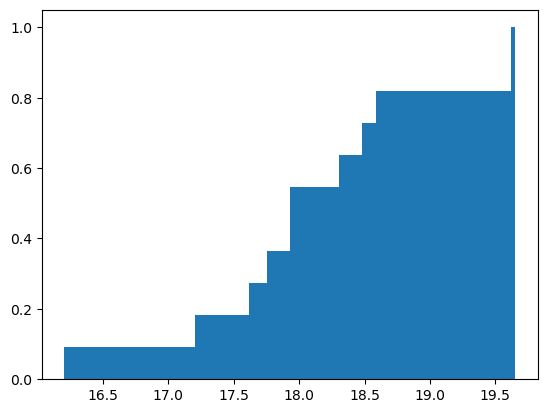

In [34]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

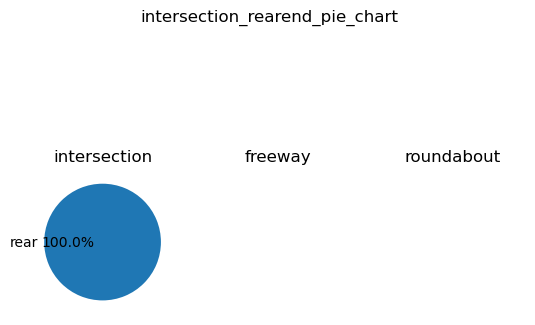

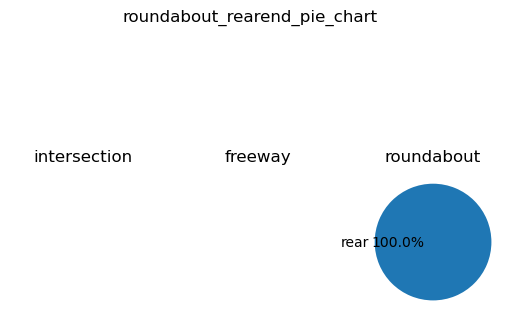

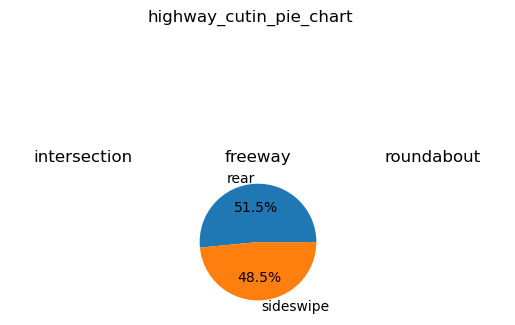

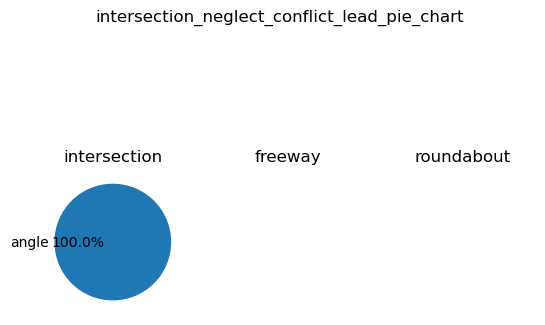

In [35]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [36]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,rear,7,0.000425,0.011647,7.070317e-07


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,rear,3,0.000018,0.004992,2.952657e-08


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,12,0.000067,0.019967,1.110965e-07
1,freeway,sideswipe,11,0.000063,0.018303,1.045143e-07


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,1,0.00001,0.001664,1.630610e-08


In [37]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.8 MB/s eta 0:00:0000:0100:01


In [38]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [39]:
A

array([[  0,  16,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 707,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  29,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 111,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 104,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

#### Calibration

In [40]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Restricted license - for non-production use only - expires 2024-10-28
Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 40 rows, 22 columns and 70 nonzeros
Model fingerprint: 0x5d64195f
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [8e+02, 4e+04]
Presolve removed 21 rows and 11 columns
Presolve time: 0.00s
Presolved: 19 rows, 11 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   5.000000e+30   2.000000e+02      0s
      12    6.7780022e+04   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.778002161e+04
 
***** Solution:
x =

### Quick check

In [41]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                        
              nunique                   first
lane_id                                      
:NODE_18_15_0       1  cosim_test_local_0_479
:NODE_22_3_0        1  cosim_test_local_0_229
EG_17_1_1_0         1    cosim_test_local_0_1

6.658000663686076e-05 5.074823397461178e-06


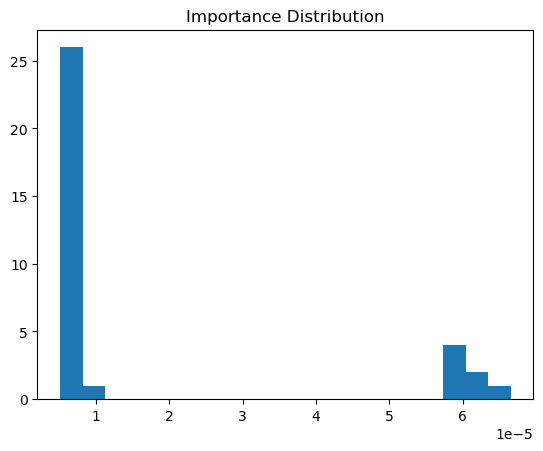

In [42]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

In [43]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [44]:
# ! pip install shapely

In [45]:
exp_stats_info

name  end_time  warmup_time  run_time crash_veh_1  \
0      cosim_test_local_0_1    1294.5         1144       720         CAV   
1      cosim_test_local_0_2    1359.1         1065       720         NaN   
2      cosim_test_local_0_3    1519.5         1132       720         NaN   
3      cosim_test_local_0_4    1421.0         1108       720         NaN   
4      cosim_test_local_0_5    1326.6         1030       720         NaN   
..                      ...       ...          ...       ...         ...   
596  cosim_test_local_0_597    1328.7          984       720         NaN   
597  cosim_test_local_0_598    1210.6         1189       720     BV_14.5   
598  cosim_test_local_0_599    1550.4         1181       720         NaN   
599  cosim_test_local_0_600    1516.3         1042       720         NaN   
600  cosim_test_local_0_601    1489.0         1032       720         NaN   

    crash_veh_2  importance  maneuver_challenge   neg_veh  neg_time_diff  \
0      BV_19.24   -0.008730                   2  BV_19.24           -1.0   
1           NaN   -0.056742                  13       NaN           -1.0   
2           NaN   -0.000000                   0       NaN           -1.0   
3           NaN   -0.000000                   0       NaN           -1.0   
4           NaN   -0.004365                   1       NaN           -1.0   
..          ...         ...                 ...       ...            ...   
596         NaN   -0.000000                   0       NaN           -1.0   
597         CAV    5.272755                   7   BV_14.5            0.6   
598         NaN   -0.004365                   1       NaN           -1.0   
599         NaN   -0.130942                  30       NaN           -1.0   
600         NaN   -0.008730                   2       NaN           -1.0   

    neg_reason       neg_info   route_length  bv_22_route_length      lane_id  \
0          NaN            NaN   25743.119024         1133.050506  EG_17_1_1_0   
1          NaN            NaN   48394.572790          898.780712          NaN   
2          NaN            NaN   77169.397664         2836.094602          NaN   
3          NaN            NaN   59589.184271         2833.284692          NaN   
4          NaN            NaN   60455.163220         1702.392321          NaN   
..         ...            ...            ...                 ...          ...   
596        NaN            NaN   68265.664639         4292.945605          NaN   
597   LeftFoll  highway_cutin    4352.907058          453.074950   EG_1_3_1_1   
598        NaN            NaN   70243.314155         4642.450564          NaN   
599        NaN            NaN  105388.061821         4396.494751          NaN   
600        NaN            NaN   88550.312606         1549.679535          NaN   

    collision_type location_type    relative_heading   distance  \
0         rear_end  intersection   4.369559478239125  -1.000000   
1              NaN           NaN                None -10.000000   
2              NaN           NaN                None -10.000000   
3              NaN           NaN                None -10.000000   
4              NaN           NaN                None -10.000000   
..             ...           ...                 ...        ...   
596            NaN           NaN                None -10.000000   
597      sideswipe     freeway_1  18.604545849139015  -1.661434   
598            NaN           NaN                None -10.000000   
599            NaN           NaN                None -10.000000   
600            NaN           NaN                None -10.000000   

     collision_severity  
0              0.000000  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
..                  ...  
596                 NaN  
597            3.892512  
598                 NaN  
599                 NaN  
600                 NaN  

[601 rows x 20 columns]

In [46]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [47]:
from tqdm import tqdm
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="./applications/driving_intelligence_test/maps/Mcity_safetest"):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

./applications/driving_intelligence_test/output/cosim_test_local/processed_data/non_neg_check_list.txt


  0%|          | 0/3 [00:00<?, ?it/s]

applications/driving_intelligence_test/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


/media/mtl/2TB/TeraSim-Remote-Access/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":
 33%|███▎      | 1/3 [00:12<00:24, 12.43s/it]/media/mtl/2TB/TeraSim-Remote-Access/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


applications/driving_intelligence_test/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


 67%|██████▋   | 2/3 [00:23<00:11, 11.67s/it]/media/mtl/2TB/TeraSim-Remote-Access/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


applications/driving_intelligence_test/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


100%|██████████| 3/3 [00:35<00:00, 11.95s/it]


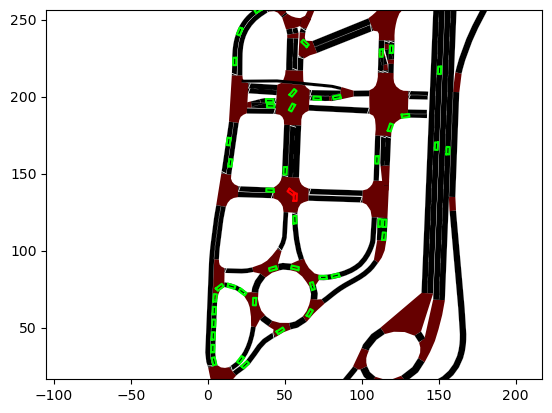

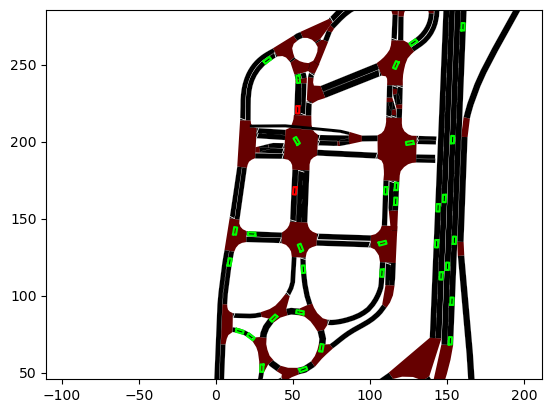

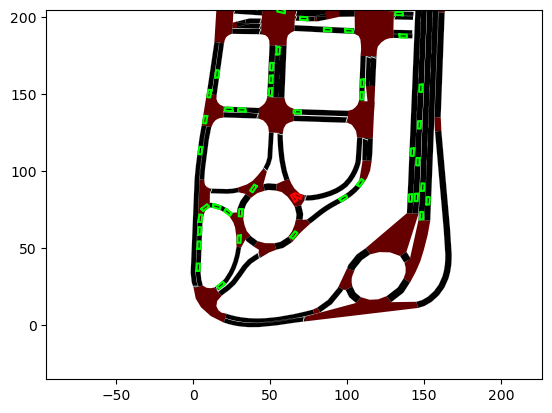

In [48]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
print(non_neg_check_list_path)
export_path = f"{exp_repo}/{exp_name}//videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

print(non_neg_check_list_path)

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

In [49]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

array([], dtype=object)

In [50]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()

array([':NODE_7_0_1', ':NODE_22_3_0', 'EG_9_1_1_0'], dtype=object)